# Flower Classification

**Exploracion de datos y Preprocesamiento**

**Yalila Aljure Jimenez**

email: yalila.aljure@udea.edu.co

CC. 5288540



**IMPORTING LIBRARIES**

In [ ]:
import tensorflow as tf
tf.__version__

'2.6.0'

In [ ]:
import keras
keras.__version__

'2.6.0'

In [ ]:
!pip install mlflow

     |████████████████████████████████| 14.6 MB 85 kB/s 
     |████████████████████████████████| 146 kB 71.6 MB/s 
     |████████████████████████████████| 1.1 MB 59.7 MB/s 
     |████████████████████████████████| 79 kB 9.9 MB/s 
     |████████████████████████████████| 56 kB 5.8 MB/s 
     |████████████████████████████████| 170 kB 67.5 MB/s 
     |████████████████████████████████| 636 kB 47.2 MB/s 
     |████████████████████████████████| 75 kB 6.0 MB/s 
     |████████████████████████████████| 52 kB 2.2 MB/s 
     |████████████████████████████████| 63 kB 2.8 MB/s 
  Created wheel for alembic: filename=alembic-1.4.1-py2.py3-none-any.whl size=158172 sha256=64d7e4a14c7b4a001a1ccaa7cb4dbd339e5326b3416bb75498505ecfe6035f46
  Stored in directory: /root/.cache/pip/wheels/be/5d/0a/9e13f53f4f5dfb67cd8d245bb7cdffe12f135846f491a283e3
  Created wheel for databricks-cli: filename=databricks_cli-0.15.0-py3-none-any.whl size=105260 sha256=e3acd9139f8e88baaacfa547a5a0280516383ad7755bdc663f3e2ff33d0c3151

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import pathlib
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib import pyplot as plt
import random

from keras.layers import Conv2D, Dropout, MaxPooling2D, BatchNormalization, Activation, Flatten, Dense, InputLayer, Input
from keras.models import Sequential, Model
import mlflow
import mlflow.keras

**LOAD DATA**

In [ ]:
!wget https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz

--2021-08-26 18:37:59--  https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 142.251.2.128, 74.125.137.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: ‘flower_photos.tgz’

flower_photos.tgz   100%[===================>] 218.21M  94.9MB/s    in 2.3s    

2021-08-26 18:38:02 (94.9 MB/s) - ‘flower_photos.tgz’ saved [228813984/228813984]



In [ ]:
# Unzipping Data
!gunzip flower_photos.tgz

In [ ]:
!tar -xvf flower_photos.tar

**Plotting Images**

In [ ]:
data_dir = pathlib.Path('flower_photos')
folder = list(data_dir.glob('*'))
images = list(data_dir.glob('*/*.jpg')) #list of all images (full path)

In [ ]:
len(images) # Number of images

3670

In [ ]:
fig = plt.figure(figsize=(20, 20))
iterable = np.array(random.sample(range(1, 3670), 54)) # Choosing 54 random images
for i in range(54):
    plt.subplot(9, 6, i+1)
    j = iterable[i]
    plt.title(str(images[j]).split('/')[-1], fontsize=10) # file name and disply as title
    plt.imshow(PIL.Image.open(images[j])) # Displaying Image
    ax = plt.axis("off")

Output hidden; open in https://colab.research.google.com to view.

**Parameters**

In [ ]:
image_size = 143 # Setting the size of the images

**Imagen Preprocessing**

Data Augmantation

Original source is not partitioned. The test set will be fixed at 20% of the entire dataset. The rest of the dataset will be used for training (0.8) and validation (0.2).

In [ ]:
idg_flip = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
    validation_split = 0.2
)

In [ ]:
flower_gen_train = idg_flip.flow_from_directory(data_dir,
                                    target_size=(image_size, image_size),
                                    subset='training',
                                    class_mode='categorical',
                                    shuffle=True,
                                    seed=123
                                    )

Found 2939 images belonging to 5 classes.


In [ ]:
flower_gen_test = idg_flip.flow_from_directory(data_dir,
                                    target_size=(image_size, image_size),
                                    subset='validation',
                                    class_mode='categorical',
                                    shuffle=True,
                                    seed=123
                                    )

Found 731 images belonging to 5 classes.


**VGGNet**

In [ ]:
# Instanciate and empty model
model = Sequential()
# First Convolutional Layer
model.add(Conv2D(64, kernel_size=(3,3), activation='PReLU',padding='same',input_shape=(image_size,image_size,3))) # 2D Convolution layer, filters = 64
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2))) # MaxPooling layer 
model.add(Conv2D(64, kernel_size=(3,3), activation='PReLU',padding='same')) # 2D Convolution layer, filters = 64
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2))) # MaxPooling layer 
model.add(BatchNormalization()) 
# Second Convolutional Layer
model.add(Conv2D(128, kernel_size=(3,3), activation='PReLU', padding='same')) # 2D Convolution layer, filters = 128
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2))) # MaxPooling layer 
model.add(Conv2D(128, kernel_size=(3,3), activation='PReLU',padding='same')) # 2D Convolution layer, filters = 128
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2))) # MaxPooling layer 
model.add(BatchNormalization()) 
# Third Convolutional Layer
model.add(Conv2D(256, kernel_size=(3,3), activation='PReLU',padding='same')) # 2D Convolution layer, filters = 256
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2))) # MaxPooling layer 
model.add(Conv2D(256, kernel_size=(3,3), activation='PReLU',padding='same')) # 2D Convolution layer, filters = 256
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2))) # MaxPooling layer 
model.add(Conv2D(256, kernel_size=(3,3), activation='PReLU',padding='same')) # 2D Convolution layer, filters = 256
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2))) # MaxPooling layer 
model.add(BatchNormalization()) 
# Fourth Convolutional Layer
model.add(Conv2D(512, kernel_size=(3,3), activation='PReLU',padding='same')) # 2D Convolution layer, filters = 512
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2),padding='same')) # MaxPooling layer 
model.add(Conv2D(512, kernel_size=(3,3), activation='PReLU',padding='same')) # 2D Convolution layer, filters = 512
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2),padding='same')) # MaxPooling layer 
model.add(Conv2D(512, kernel_size=(3,3), activation='PReLU',padding='same')) # 2D Convolution layer, filters = 512
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2),padding='same')) # MaxPooling layer 
model.add(BatchNormalization()) 
# Fith convolutional layer 
model.add(Conv2D(512, kernel_size=(3,3), activation='PReLU',padding='same')) # 2D Convolution layer, filters = 512
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2),padding='same')) # MaxPooling layer 
model.add(Conv2D(512, kernel_size=(3,3), activation='PReLU',padding='same')) # 2D Convolution layer, filters = 512
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2),padding='same')) # MaxPooling layer 
model.add(Conv2D(512, kernel_size=(3,3), activation='PReLU',padding='same')) # 2D Convolution layer, filters = 512
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2),padding='same')) # MaxPooling layer 
model.add(BatchNormalization()) 
# 1st dense layer
model.add(Flatten()) 
model.add(Dense(4096))
# Dropout
model.add(Dropout(0.5)) 
model.add(Activation('PReLU'))
# 2nd Dense Layer
model.add(Dense(4096))
# Dropout
model.add(Dropout(0.5))
# Normalization
model.add(BatchNormalization()) 
model.add(Activation('PReLU'))
# Output softmax layer
model.add(Dense(5))
model.add(Activation('softmax')) 

In [ ]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 143, 143, 64)      1310528   
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 71, 71, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 71, 71, 64)        359552    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 35, 35, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 35, 35, 128)       230656    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0

In [ ]:
mlflow.keras.autolog()

In [ ]:
Result = model.fit(flower_gen_train, validation_data=flower_gen_test
                  , epochs=20, verbose=1, shuffle=True)

2021/08/26 18:38:16 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2d1add6746c843628d43d33e587d802f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current keras workflow


Epoch 1/20
92/92 [==============================] - 61s 306ms/step - loss: 1.5117 - accuracy: 0.4195 - val_loss: 1.6064 - val_accuracy: 0.2449
Epoch 2/20
92/92 [==============================] - 27s 294ms/step - loss: 1.3028 - accuracy: 0.5253 - val_loss: 1.6092 - val_accuracy: 0.2449
Epoch 3/20
92/92 [==============================] - 27s 293ms/step - loss: 1.1946 - accuracy: 0.5628 - val_loss: 1.5988 - val_accuracy: 0.2640
Epoch 4/20
92/92 [==============================] - 27s 292ms/step - loss: 1.0900 - accuracy: 0.5985 - val_loss: 1.5687 - val_accuracy: 0.3133
Epoch 5/20
92/92 [==============================] - 27s 294ms/step - loss: 1.0262 - accuracy: 0.6199 - val_loss: 1.4313 - val_accuracy: 0.4542
Epoch 6/20
92/92 [==============================] - 27s 293ms/step - loss: 1.0038 - accuracy: 0.6284 - val_loss: 1.2138 - val_accuracy: 0.5677
Epoch 7/20
92/92 [==============================] - 27s 294ms/step - loss: 0.9699 - accuracy: 0.6458 - val_loss: 1.1312 - val_accuracy: 0.5540

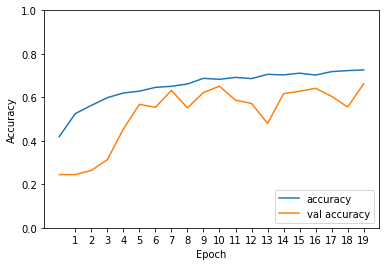

In [ ]:
plt.plot(Result.history['accuracy'], label='accuracy')
plt.plot(Result.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(list(range(1,20)))
plt.ylim([0, 1])
plt.legend(loc='lower right')

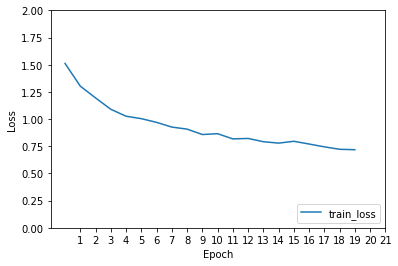

In [ ]:
plt.plot(Result.history['loss'], label='train_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(list(range(1,22)))
plt.ylim([0, 2])
plt.legend(loc='lower right')